## 0. Import library

In [3]:
# Basic
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
pd.options.display.float_format = "{:,.4f}".format
import gc

import re

import warnings;
warnings.filterwarnings('ignore')

In [4]:
# model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score


## 1. Import data

In [5]:
# df = pd.read_csv('reviews_cleaned.csv', parse_dates=['timestamp_created'])


df = pd.read_csv('Scraped data\scraped_data_559k.csv', parse_dates=['timestamp_created'])

In [6]:
df.head()

recommendationid                                             review  \
0         132354840  Loe, love, LOVE this game.\n\nI purchased it w...   
1         132354525                                 shouldve been more   
2         132354176                                           It's fun   
3         132353890                                   full gen z game.   
4         132353500                                it good that is all   

  timestamp_created  voted_up  
0        1675747403      True  
1        1675746707     False  
2        1675745970      True  
3        1675745336     False  
4        1675744599      True

In [7]:
 df['voted_up'].value_counts(), df['voted_up'].value_counts(normalize = True)

(True     385474
 False    173649
 Name: voted_up, dtype: int64,
 True    0.6894
 False   0.3106
 Name: voted_up, dtype: float64)

**Drop nulls**

In [8]:
df['review'].isna().value_counts()

False    557447
True       1676
Name: review, dtype: int64

In [9]:
df.dropna(subset='review', inplace=True)

In [10]:
df['review'].isna().value_counts()

False    557447
Name: review, dtype: int64

**Drop duplicates**

In [11]:
df['review'].duplicated().value_counts()

False    465791
True      91656
Name: review, dtype: int64

In [12]:
df.drop_duplicates(subset='review', keep='first', inplace=True)

In [13]:
df['review'].duplicated().value_counts()

False    465791
Name: review, dtype: int64

**Convert timestamp_created to datetime**

In [14]:
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'],unit='s')
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'].dt.date)
df.head()

recommendationid                                             review  \
0         132354840  Loe, love, LOVE this game.\n\nI purchased it w...   
1         132354525                                 shouldve been more   
2         132354176                                           It's fun   
3         132353890                                   full gen z game.   
4         132353500                                it good that is all   

  timestamp_created  voted_up  
0        2023-02-07      True  
1        2023-02-07     False  
2        2023-02-07      True  
3        2023-02-07     False  
4        2023-02-07      True

**Remove formatting**

In [15]:
def remove_markdown(input_string):
    input_string = str(input_string)
    result = re.sub(r'\[.*?\]', '', input_string)
    result = ' '.join(result.split()) #replace multiple spaces with single space

    return result

In [16]:
df.review = df.review.apply(remove_markdown)

## 2. Exclude holdout

### Exclude 5% of the most recent reviews for holdout set

<Axes: xlabel='timestamp_created', ylabel='Count'>

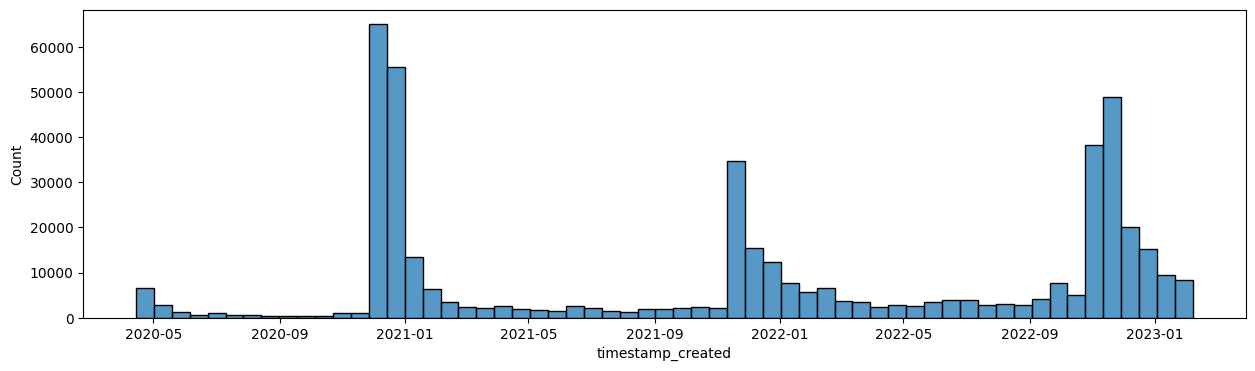

In [17]:
plt.figure(figsize=(15,4))
sns.histplot(x=df.timestamp_created)

In [18]:
# date of 95th quantile reviews
df.timestamp_created.quantile(0.95)

Timestamp('2022-12-28 00:00:00')

In [19]:
%%time
X = df['review']

# X_holdout = X[df.timestamp_created >= df.timestamp_created.quantile(0.95)]
X = X[df.timestamp_created < df.timestamp_created.quantile(0.95)]

X

CPU times: total: 0 ns
Wall time: 11 ms


6903      great game, you might have to update you GPU t...
6904      They've fixed the game up pretty well, only a ...
6905                 cuz i really wanna stay at your housee
6906                 Finally! the game and story are great!
6907                                                      ء
                                ...                        
559118    GAME WAJIB UNTUK BUDAK EA, SUNGKEM YANG MULIA ...
559119    A lot of Change by FIFA afterall. Finally have...
559120    This is the first time I played Ultimate Team ...
559121    i loved the game so much, and i've been waitin...
559122                       It's Fifa, nothing else to say
Name: review, Length: 442006, dtype: object

In [20]:
y = df['voted_up'][df.timestamp_created < df.timestamp_created.quantile(0.95)]
# y_holdout = df['voted_up'][df.timestamp_created >= df.timestamp_created.quantile(0.95)]

## 3. Pretrained models

### Data

In [49]:
X_train, _ , y_train, __ = train_test_split(X, y, stratify = y, train_size=0.1, random_state=14)
del _,__

### VADER

In [99]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nguye_5159g\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [100]:
SentAnalyzer = SentimentIntensityAnalyzer()

Make prediction

In [101]:
%%time
# CPU times: total: 2min 38s
# Wall time: 3min
result = X_train.astype(str).apply(SentAnalyzer.polarity_scores)

CPU times: total: 2min 38s
Wall time: 3min


In [102]:
%%time
df_result = result.apply(lambda x: pd.Series([x['neg'], x['neu'], x['pos'], x['compound']]))
df_result.columns = ['neg', 'neu', 'pos', 'compound']
df_result['actual'] = y_train.map({True: 1, False: 0})
df_result['review'] = X_train
df_result

CPU times: total: 31.9 s
Wall time: 36.4 s


neg    neu    pos  compound  actual  \
115951 0.0570 0.4200 0.5220    0.9617       1   
163064 0.0710 0.6970 0.2320    0.9707       1   
510803 0.0000 0.3710 0.6290    0.6240       1   
409945 0.0000 1.0000 0.0000    0.0000       0   
39614  0.0640 0.7630 0.1730    0.8055       1   
...       ...    ...    ...       ...     ...   
556977 0.2260 0.7110 0.0630   -0.9212       0   
105996 0.0000 0.8980 0.1020    0.3612       0   
460745 0.0000 0.6610 0.3390    0.6249       1   
279300 0.5560 0.0000 0.4440   -0.1779       0   
251645 0.0000 0.3230 0.6770    0.7425       1   

                                                   review  
115951  REALLY REALLY good story. A few bugs but nothi...  
163064  Just to be clear, I've not experienced many of...  
510803                        Thank you Kanye, very cool.  
409945                    FPS drops harder than the bass.  
39614   The game is everything I had been waiting for ...  
...                                                   ...  
556977  THIS IS THE WORST GAME ON ANY PLATFORM. WHAT A...  
105996  CDPR "It'll come out when it's ready" CyberPun...  
460745  That was a Masterpiece & (MW22 >>>> MW19) - My...  
279300                                           lol fail  
251645                 Interesting gameplay and very fun.  

[353604 rows x 6 columns]

Convert compound score (-1, 1) to (0, 1)

In [104]:
y_proba = result.apply(lambda x: (x['compound']+1)/2)

<Axes: xlabel='review', ylabel='Count'>

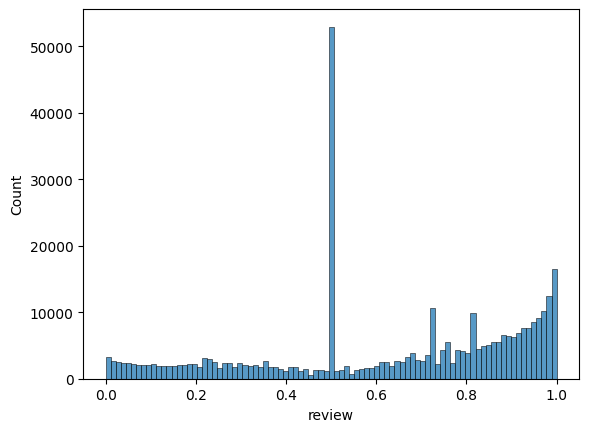

In [105]:
sns.histplot(x=y_proba)

In [61]:
def cf_report(y_actual, y_pred):
    print(classification_report(y_actual, y_pred))

    labels = ['Negative', 'Positive']

    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True,
                cbar=False, xticklabels=labels, yticklabels=labels, fmt='.0f')
    plt.ylabel('Actual'), plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

              precision    recall  f1-score   support

       False       0.56      0.65      0.60    120841
        True       0.80      0.73      0.77    232763

    accuracy                           0.70    353604
   macro avg       0.68      0.69      0.68    353604
weighted avg       0.72      0.70      0.71    353604



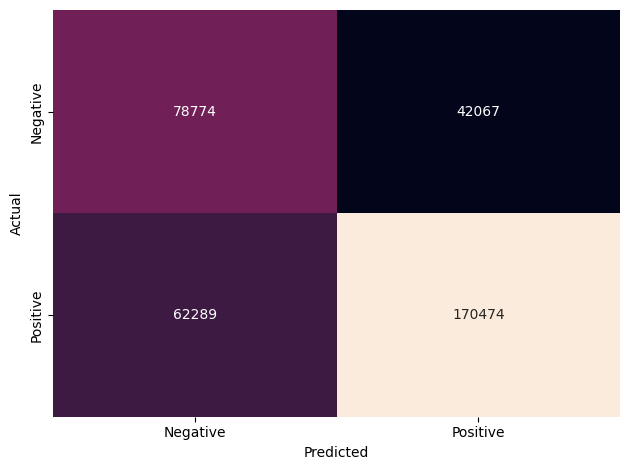

In [107]:
threshold = 0.5
yhat = y_proba>threshold

cf_report(y_train, yhat)

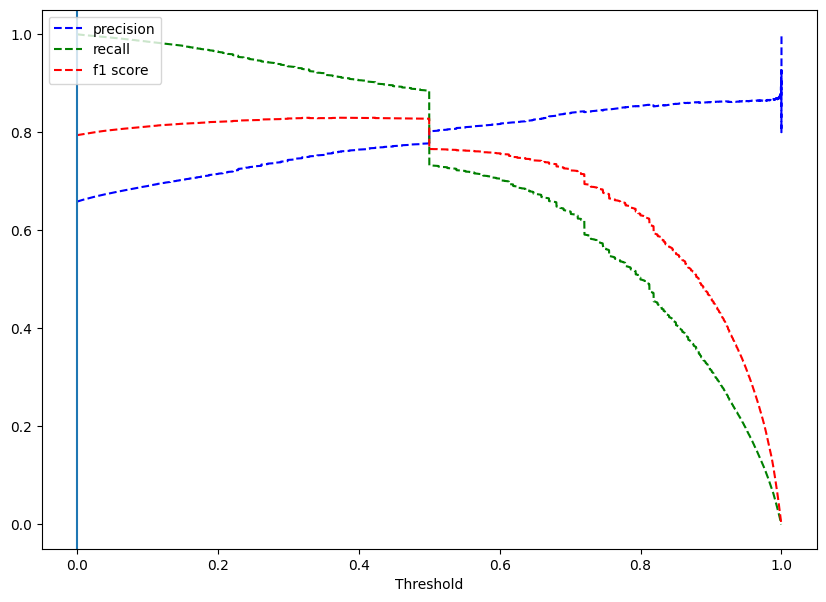

In [108]:
# function to plot precision/recall curve
def pre_rec_curve(y_actual, y_proba, threshold=0.5):
    precisions, recalls, thresholds = precision_recall_curve(y_actual, y_proba)
    thresholds = np.insert(thresholds, 0, 0)
    F1_score = 2*precisions*recalls/(precisions+recalls)

    # Plot values of precisions, recalls, and thresholds
    plt.figure(figsize=(10,7))
    plt.plot(thresholds, precisions, 'b--', label='precision')
    plt.plot(thresholds, recalls, 'g--', label = 'recall')
    plt.plot(thresholds, F1_score, 'r--', label = 'f1 score')

    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    # plt.ylim([0.6,1])
    plt.axvline(threshold)
    plt.show()

pre_rec_curve(y_train, y_proba, threshold=0)

### ROBERTA

In [23]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [44]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [35]:
example_good = 'I love this game'

In [36]:
# Run for Roberta Model
encoded_text = tokenizer(example_good, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0038582087, 'roberta_neu': 0.0079186065, 'roberta_pos': 0.98822314}


In [56]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt', max_length=50, truncation=True)
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [64]:
%%time
result = X_train[:10000].astype(str).apply(polarity_scores_roberta)

CPU times: total: 29min 6s
Wall time: 6min 35s


In [65]:
df_result = result.apply(lambda x: pd.Series([x['roberta_neg'], x['roberta_neu'], x['roberta_pos']]))
df_result.columns = ['neg', 'neu', 'pos']
df_result['actual'] = y_train.map({True: 1, False: 0})
df_result['review'] = X_train
df_result

neg    neu    pos  actual  \
474761 0.0083 0.1059 0.8859       1   
475647 0.0016 0.1040 0.8944       0   
204613 0.0044 0.1133 0.8822       1   
438891 0.1304 0.2429 0.6267       1   
32312  0.0017 0.0296 0.9687       1   
...       ...    ...    ...     ...   
490294 0.0564 0.2266 0.7170       0   
98617  0.5370 0.4361 0.0269       1   
85951  0.0044 0.0209 0.9747       1   
490766 0.0432 0.5103 0.4465       1   
10824  0.8076 0.1460 0.0464       0   

                                                   review  
474761  Initial rollout and already the best CoD. It l...  
475647                    Logging into online services :)  
204613  100% worth buying just make sure you have good...  
438891  Maps are trash, and the new leveling-up is fun...  
32312   rlly good looking game. even on the rtx 2060 1...  
...                                                   ...  
490294  Pointless game -Graphics: 7/10 Fallout 4 with ...  
98617                          PC version or don't buy it  
85951   Great game if you've got the hardware for it. ...  
490766                                 gud game, gud laif  
10824   combat and aiming are terrible. game is a joke...  

[10000 rows x 5 columns]

In [74]:
df_result.query('actual==1').head(20)

neg    neu    pos  actual  \
474761 0.0083 0.1059 0.8859       1   
204613 0.0044 0.1133 0.8822       1   
438891 0.1304 0.2429 0.6267       1   
32312  0.0017 0.0296 0.9687       1   
531476 0.2001 0.6701 0.1298       1   
481680 0.1063 0.6959 0.1978       1   
146962 0.0040 0.0203 0.9757       1   
419049 0.1211 0.7797 0.0992       1   
477785 0.0026 0.0299 0.9675       1   
452906 0.0252 0.6857 0.2891       1   
459211 0.0649 0.0825 0.8526       1   
320735 0.0055 0.0179 0.9766       1   
258453 0.0012 0.0104 0.9885       1   
157113 0.1898 0.7391 0.0711       1   
86166  0.0071 0.0584 0.9345       1   
445082 0.9610 0.0349 0.0041       1   
33481  0.4442 0.5017 0.0541       1   
253732 0.1707 0.7576 0.0717       1   
487319 0.0034 0.0286 0.9680       1   
78507  0.1769 0.6367 0.1864       1   

                                                   review  
474761  Initial rollout and already the best CoD. It l...  
204613  100% worth buying just make sure you have good...  
438891  Maps are trash, and the new leveling-up is fun...  
32312   rlly good looking game. even on the rtx 2060 1...  
531476                                               rgwg  
481680                                      ok. but worth  
146962  Really enjoyed the spectacle. Lot of love pour...  
419049                                              1 > 2  
477785  First crashhhh GG, its oke cuz this is masterp...  
452906                       Alright game. The usual COD.  
459211  this game has brought the negativty in me and ...  
320735                                          love it!!  
258453  It's actually good and fun now. It's getting c...  
157113  Das Spiel ist dermaßen immersiv, dass man gar ...  
86166   This game has come a long way from launch, and...  
445082  i like. pls no more sbmm my butthole cant take it  
33481     there's only 2 dudes you can have sex with, smh  
253732                            Игра очень понравилась.  
487319                    Great Game with the new updates  
78507                  You can practically smell the city

              precision    recall  f1-score   support

       False       0.63      0.86      0.73      3366
        True       0.91      0.75      0.82      6634

    accuracy                           0.79     10000
   macro avg       0.77      0.80      0.78     10000
weighted avg       0.82      0.79      0.79     10000



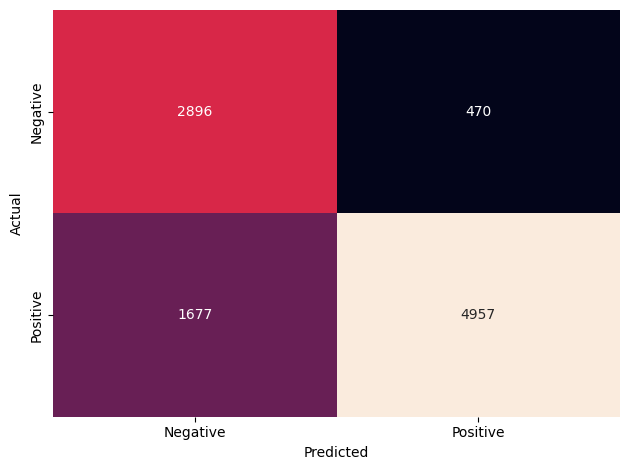

In [75]:
yhat = df_result.pos>df_result.neg
cf_report(y_train[:10000], yhat)